## Training (Fitting) Machine Learning Models
- Train and Test Models using a Variety of Appropriate [Classification] Algorithms
- Tune (Optimize) Each Model''s Hyperparameters
- Perform K-Fold Cross-Validation Using Each Model
- Evaluate the Optimally-Fitted Models Against a Hold-Out (Out-of-Sample) Dataset
- Determine Each Model''s Accuracy and Identify the Best Model.

### Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import sklearn
print("SciKit-Learn Version:", sklearn.__version__)

if sklearn.__version__ >= '0.18.0':  # Starting with sklearn version 18.0
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
else:
    from sklearn.cross_validation import train_test_split, cross_val_score
    from sklearn.cross_validation import GridSearchCV, RandomizedSearchCV
    
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

SciKit-Learn Version: 0.24.1


### Define Globals

In [2]:
hold_out_percent = 0.2
CLASSIFICATION_TYPE = 'Binary'

###################################################################################################################
# Analyze Input DataTypes and Determine Their Appropriate Conversions for ML
###################################################################################################################
def set_datatypes(dframe):
    for col in dframe.columns:
        if dframe[col].dtypes.str.startswith('int'):
            dframe[col] = pd.to_numeric(dframe[col],
                                        downcast='integer',
                                        errors='coerce')
            
        elif dframe[col].dtypes.str.startswith('float'):
            dframe[col] = pd.to_numeric(dframe[col],
                                        downcast='float',
                                        errors='coerce')
            
        elif dframe[col].dtypes == 'object':
            dframe[col] = dframe[col].astype('category')
        
    return dframe


###################################################################################################################
# Calculate the Null Accuracy Score: Accommodates Binary or Multiple Classification Type
###################################################################################################################
def null_accuracy_score(labels, classification_type):  #NOTE: 'labels' must be a pd.Series
    if classification_type == CLASSIFICATION_TYPE:
        return max(labels[:,].astype(int).mean(), 1 - labels[:,].astype(int).mean())
    
    elif classification_type == CLASSIFICATION_TYPE:
        return labels.value_counts().head(1).item() / len(labels) 
    
    else:
        raise ValueError("Bad input {0}. Must specify either 'Binary' or 'Multiple'.".format(classification_type))
        

##################################################################################################################
# Print Evaluation Metrics: Accuracy and Null Accuracy Scores
###################################################################################################################
def show_accuracy(y_actuals, y_predictions, classification_type):
    accuracy = accuracy_score(y_actuals, y_predictions)
    null_accuracy = null_accuracy_score(y_actuals, classification_type)

    print('----------------------------------------------------------------------------------')
    print('Accuracy (The Percentage of Correct Predictions): %0.3f' % accuracy)
    print('----------------------------------------------------------------------------------')
    print('Null Accuracy (Achieved by Always Predicting the Most Frequent Class): %0.3f' % null_accuracy)
    print('----------------------------------------------------------------------------------')   
    print('True:', list(y_actuals[0:10]))
    print('Pred:', y_predictions[0:10].tolist())
    print('----------------------------------------------------------------------------------\n')
        

##################################################################################################################
# Print Skree Plots: Compare the Explained Variances per Component Between Train/Test and Hold-Out Datasets
###################################################################################################################
def show_skree_plots(components, variances_explained):
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(7, 7))
    
    ax0.set_title("PCA Explained Variances: Train/Test Data")
    ax0.scatter(components, variances_explained[0])
    ax0.set_ylabel('Explained Variance (Eigenvalues)')
    ax0.grid(True)

    ax1.set_title("PCA Explained Variances: Hold-Out Data")
    ax1.scatter(components, variances_explained[1])
    ax1.set_ylabel('Explained Variance (Eigenvalues)')
    ax1.set_xlabel('Number of Components (Eigenvectors)')
    ax1.grid(True)

    plt.tight_layout()
    plt.show()
        

###################################################################################################################
# Print a Confusion Matrix:  Accommodates Binary or Multiple Classification Type
###################################################################################################################
def show_confusion_matrix(y_actuals, y_predictions, y_probabilities, classification_type):
    print('-------------------------------------------------------')
    print('Confusion Matrix')
    print('-------------------------------------------------------')

    cm = pd.crosstab(y_actuals, y_predictions, rownames=['Actuals'], colnames=['Predictions'])
    print(cm)
        
    if classification_type == CLASSIFICATION_TYPE:
        print('-------------------------------------------------------')
        print('Area Under the Curve (AUC): %0.3f' % roc_auc_score(y_actuals, y_probabilities[:, 1]))
        
    print('-------------------------------------------------------\n')
    
    
###################################################################################################################
# Print a Classification Report
###################################################################################################################
def show_classification_report(y_actuals, y_predictions):
    print('-------------------------------------------------------')
    print('Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_actuals, y_predictions))
    print('-------------------------------------------------------\n')
    
    
###################################################################################################################
# Print a Classification Report Resulting from K-Fold Cross-Validation
###################################################################################################################
def show_cv_classification_report(classifier, X, y, K):
    accuracy = cross_val_score(classifier, X, y, scoring='accuracy', cv=K)
    print('--------------------------------------------------------------------------------------------')
    print("Accuracy per Fold: ", accuracy)
    print("Average Accuracy: %0.3f" % accuracy.mean())
    print("Standard Deviation of Accuracy: %0.3f" % accuracy.std())
    print('--------------------------------------------------------------------------------------------')
    
    precision = cross_val_score(classifier, X, y, scoring='precision_weighted', cv=K)
    print("Precision per Fold: ", precision)
    print("Average Precision: %0.3f" % precision.mean())
    print("Standard Deviation of Precision: %0.3f" % precision.std())
    print('--------------------------------------------------------------------------------------------')
    
    recall = cross_val_score(classifier, X, y, scoring='recall_weighted', cv=K)
    print("Recall per Fold: ", recall)
    print("Average Recall: %0.3f" % recall.mean())
    print("Standard Deviation of Recall: %0.3f" % recall.std())
    print('--------------------------------------------------------------------------------------------')
    
    f1 = cross_val_score(classifier, X, y, scoring='f1_weighted', cv=K)
    print("F1 per Fold: ", f1)
    print("Average F1: %0.3f" % f1.mean())
    print("Standard Deviation of F1: %0.3f" % f1.std())
    print('--------------------------------------------------------------------------------------------')
    

###################################################################################################################
# Print a Receiver Operating Characteristic (ROC) Curve Plot (Binary Classification Only).
###################################################################################################################
def show_roc_plot(y_actuals, y_probabilities, classifier_algorithm):
    plt.figure(figsize=(5,5))
    plt.title('ROC Curve (' + classifier_algorithm + ')')

    fpr, tpr, _ = roc_curve(y_actuals, y_probabilities[:, 1])
    auc = roc_auc_score(y_actuals, y_probabilities[:, 1])

    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (area = %0.2f)' % auc)
    plt.plot([0,1], [0,1], color='steelblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    

###################################################################################################################
# Save a Trained Model to a Pickle File.
###################################################################################################################
def export_model(model, algorithm_name):
    file_name = "Customer_Churn_{0}.pkl".format(algorithm_name)
    file_target = open(os.path.join(os.getcwd(), 'Models', file_name), 'wb')
    pickle.dump(model, file_target, protocol=pickle.HIGHEST_PROTOCOL)
    file_target.close()

### Load Data

In [3]:
# Locate the Data File to be Ingested.
data_dir = os.path.join(os.getcwd(), 'Data')
source_file = os.path.join(data_dir, 'WA-Telco-Customer-Churn-ML.csv')

# Read the Data from the Source File
df = pd.read_csv(source_file, header=0, index_col=0)

# Drop the Unique Identifier
df = df.drop(labels=['Customerid'], axis=1)

# Display the Dimensions of the DataSet Being Used.
print("DataSet Dimensions:", df.shape)

DataSet Dimensions: (7043, 20)


#### Make Appropriate Data Type Assignments.

In [4]:
df = set_datatypes(df)
df.dtypes

Gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
Tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

#### Separate the Independant (Predictor) Variables (X) from the Dependant (Target, Response, or Label) Variable (y)

In [5]:
X = df.drop(labels=['Churn'], axis=1)
y = df.Churn

### Select Features Based on Feature Selection Exercises

In [6]:
X = df[['TotalCharges','MonthlyCharges','Tenure','Contract',
        'PaymentMethod'
        #,'OnlineSecurity'
        , 'InternetService'
    ]]

#### Quickly Compare the Performance of Popular Classification Algorithms

In [7]:
clfs = []
clf_names = []
accuracy_scores = []

clfs.append( KNeighborsClassifier() )
clfs.append( SGDClassifier(random_state=7) )
clfs.append( DecisionTreeClassifier(random_state=7) )
clfs.append( AdaBoostClassifier(random_state=7) )
clfs.append( GradientBoostingClassifier(random_state=7) )
clfs.append( RandomForestClassifier(random_state=7) )

for clf in clfs:
    clf.fit(X, y)
    name = str(type(clf)).split('.')[3][:-2]
    clf_names.append(name)
    accuracy_scores.append(cross_val_score(clf, X, y, scoring='accuracy', cv=10).mean().round(4))
    
# Create a new DataFrame to hold the report
report = pd.DataFrame()
report['Accuracy'] = accuracy_scores
report['Classifier'] = clf_names
    
# Finally, display the report    
report.sort_values(by=['Accuracy'], ascending=False).reset_index(drop=True)

,Accuracy,Classifier
0,0.7941,GradientBoostingClassifier
1,0.7927,AdaBoostClassifier
2,0.7752,RandomForestClassifier
3,0.7612,KNeighborsClassifier
4,0.7282,DecisionTreeClassifier
5,0.6762,SGDClassifier


### Train a Baseline Classifier Using K-Nearest Neighbors and K-Fold Cross-Validation

In [8]:
%%time

knn = KNeighborsClassifier()
show_cv_classification_report(knn, X, y, 10)

--------------------------------------------------------------------------------------------
Accuracy per Fold:  [0.74468085 0.7787234  0.77304965 0.76704545 0.76278409 0.74573864
 0.76278409 0.75284091 0.75       0.77414773]
Average Accuracy: 0.761
Standard Deviation of Accuracy: 0.012
--------------------------------------------------------------------------------------------
Precision per Fold:  [0.73175866 0.76454283 0.7585886  0.75445766 0.7463076  0.73039735
 0.75091315 0.7335514  0.73821016 0.76104997]
Average Precision: 0.747
Standard Deviation of Precision: 0.012
--------------------------------------------------------------------------------------------
Recall per Fold:  [0.74468085 0.7787234  0.77304965 0.76704545 0.76278409 0.74573864
 0.76278409 0.75284091 0.75       0.77414773]
Average Recall: 0.761
Standard Deviation of Recall: 0.012
--------------------------------------------------------------------------------------------
F1 per Fold:  [0.7365611  0.76733222 0.7619597

#### Perform Hyper-Parameter Tuning

In [9]:
%%time

# Define the parameter values to be searched
k_range = list(range(2, 26))
weight_options = ['uniform','distance']

# Create a parameter grid
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, n_jobs=-1)

# Finally, fit the grid
grid.fit(X, y)

CPU times: user 659 ms, sys: 84.8 ms, total: 744 ms
Wall time: 5.45 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

#### View the Results

In [10]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head()

,mean_test_score,std_test_score,params
0,0.761323,0.012801,"{'n_neighbors': 2, 'weights': 'uniform'}"
1,0.719434,0.015010,"{'n_neighbors': 2, 'weights': 'distance'}"
2,0.750672,0.015361,"{'n_neighbors': 3, 'weights': 'uniform'}"
3,0.741867,0.018018,"{'n_neighbors': 3, 'weights': 'distance'}"
4,0.767002,0.010536,"{'n_neighbors': 4, 'weights': 'uniform'}"


In [11]:
mean_test_scores = grid.cv_results_['mean_test_score']
params = grid.cv_results_['params']

items = list(range(0, len(params)))
weights = []

for i in items:
    weights.append(params[i]['weights'])

results = pd.DataFrame({'scores':mean_test_scores, 'weights':weights})      
uniform_scores = results[results.weights == 'uniform'].scores
distance_scores = results[results.weights == 'distance'].scores

print('----------------------------------------------------------------------------------')
print('Mean Test Scores (Uniform):', round(uniform_scores, 3).tolist())
print('----------------------------------------------------------------------------------')
print('Mean Test Scores (Distance):', round(distance_scores, 3).tolist())
print('----------------------------------------------------------------------------------')
print('K-Range Values:', k_range)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
Mean Test Scores (Uniform): [0.761, 0.751, 0.767, 0.761, 0.778, 0.775, 0.783, 0.781, 0.785, 0.784, 0.783, 0.782, 0.782, 0.78, 0.782, 0.783, 0.783, 0.785, 0.783, 0.785, 0.783, 0.786, 0.783, 0.784]
----------------------------------------------------------------------------------
Mean Test Scores (Distance): [0.719, 0.742, 0.748, 0.754, 0.757, 0.762, 0.767, 0.771, 0.774, 0.775, 0.774, 0.775, 0.777, 0.774, 0.775, 0.776, 0.777, 0.777, 0.778, 0.779, 0.779, 0.781, 0.783, 0.784]
----------------------------------------------------------------------------------
K-Range Values: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
----------------------------------------------------------------------------------


#### Plot the Mean Test Scores by Weight Against the Number of Neighbors (K)

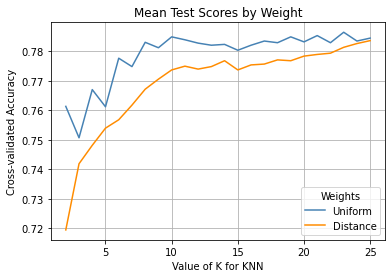

In [12]:
# Plot the scores
plt.title('Mean Test Scores by Weight')
plt.plot(k_range, uniform_scores, color='steelblue', label='Uniform')
plt.plot(k_range, distance_scores, color='darkorange', label='Distance')
plt.legend(loc='lower right', title='Weights')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)

In [13]:
# Examine the best score
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7864541021921342
{'n_neighbors': 23, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=23)


#### Use the Best Hyper-Parameters to Make Predictions Using Hold-Out Data

In [14]:
%%time

n_neighbors = grid.best_params_['n_neighbors']
weights_option = grid.best_params_['weights']

knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights_option)
show_cv_classification_report(knn, X, y, 10)

--------------------------------------------------------------------------------------------
Accuracy per Fold:  [0.7787234  0.80141844 0.78297872 0.77840909 0.79119318 0.77556818
 0.80113636 0.77556818 0.78267045 0.796875  ]
Average Accuracy: 0.786
Standard Deviation of Accuracy: 0.010
--------------------------------------------------------------------------------------------
Precision per Fold:  [0.76377034 0.78994081 0.76692217 0.76157915 0.77730751 0.75674885
 0.78930483 0.75687374 0.76649365 0.78431713]
Average Precision: 0.771
Standard Deviation of Precision: 0.012
--------------------------------------------------------------------------------------------
Recall per Fold:  [0.7787234  0.80141844 0.78297872 0.77840909 0.79119318 0.77556818
 0.80113636 0.77556818 0.78267045 0.796875  ]
Average Recall: 0.786
Standard Deviation of Recall: 0.010
--------------------------------------------------------------------------------------------
F1 per Fold:  [0.76614421 0.78288202 0.7576773

### Partition Dataset for Training, Testing and Evaluating Models
#### Create a Hold-Out Data Set for Model Evaluation

In [15]:
# Divide into Train/Test and Evaluation (Hold-Out) Sets.
X, X_eval, y, y_eval = train_test_split(X, y, test_size = hold_out_percent, random_state=42)

# Use 80% of the observations for training and testing...
print('-------------------------------------------------------------------')
print("Train/Test Observations:", X.shape)

# ...And hod out the rest for final evaluation.
print("Evaluation Observations:", X_eval.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Train/Test Label Distribution:\n", y.value_counts())
print('-------------------------------------------------------------------')
print("Evaluation Label Distribution:\n", y_eval.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Train/Test Observations: (5634, 6)
Evaluation Observations: (1409, 6)
-------------------------------------------------------------------

Train/Test Label Distribution:
 0    4138
1    1496
Name: Churn, dtype: int64
-------------------------------------------------------------------
Evaluation Label Distribution:
 0    1036
1     373
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Create Training and Testing Datasets 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 60% of the observations for training...
print('-------------------------------------------------------------------')
print("Training Observations:", X_train.shape)

# ...And use the rest for testing.
print("Testing Observations:", X_test.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Training Label Distribution:\n", y_train.value_counts())
print('-------------------------------------------------------------------')
print("Testing Label Distribution:\n", y_test.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Training Observations: (4507, 6)
Testing Observations: (1127, 6)
-------------------------------------------------------------------

Training Label Distribution:
 0    3316
1    1191
Name: Churn, dtype: int64
-------------------------------------------------------------------
Testing Label Distribution:
 0    822
1    305
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Perform Scalar Standardization of Each Dataset.

In [17]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X = sc.fit_transform(X)
X_eval = sc.transform(X_eval)

### Train a Classification Model Using the GradiantBoostingClassifier 

In [18]:
%%time

# Train using the Training data.
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Make Predictions using the Test data.
y_pred = gbc.predict(X_test)
y_probs = gbc.predict_proba(X_test)

CPU times: user 600 ms, sys: 0 ns, total: 600 ms
Wall time: 598 ms


#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.782
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.729
----------------------------------------------------------------------------------
True: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Pred: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions    0    1
Actuals              
0            734   88
1            158  147
-------------------------------------------------------
Area Under the Curve (AUC): 0.827
-------------------------------------------------------

-------------------------------------------------------
Classification Report
------------------

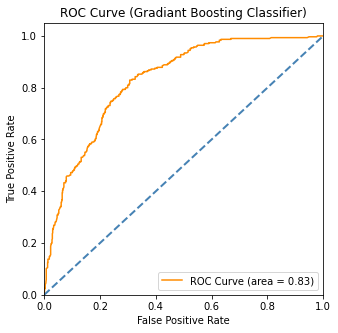

In [19]:
show_accuracy(y_test, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_test, y_pred, y_probs, CLASSIFICATION_TYPE)
show_classification_report(y_test, y_pred)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_test, y_probs, 'Gradiant Boosting Classifier')

#### Perform Hyper-Parameter Tuning for the Gradiant Boosting Classifier

In [20]:
%%time

# Define the parameter values to be searched
estimator_range = [100, 200, 300,400, 500]
learning_rate_range = [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
max_features_options = [None, 'auto','sqrt','log2']
max_depth_range = list(range(1, 10))

# Create parameter distributions
param_dist = dict(n_estimators = estimator_range
                  , learning_rate = learning_rate_range
                  , max_features = max_features_options
                  , max_depth = max_depth_range
                 )

# Instantiate the grid
rand = RandomizedSearchCV(gbc, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1) 
rand.return_train_score=False

# Finally, fit the grid
rand.fit(X_train, y_train)

CPU times: user 622 ms, sys: 52.4 ms, total: 674 ms
Wall time: 49.9 s


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.4, 0.6, 0.8, 1.0],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='accuracy')

#### View the Results

In [21]:
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.750616,0.012521,"{'n_estimators': 200, 'max_features': 'auto', ..."
1,0.764371,0.015266,"{'n_estimators': 100, 'max_features': None, 'm..."
2,0.752398,0.023369,"{'n_estimators': 500, 'max_features': 'sqrt', ..."
3,0.766147,0.015198,"{'n_estimators': 100, 'max_features': 'sqrt', ..."
4,0.798544,0.011280,"{'n_estimators': 100, 'max_features': 'log2', ..."
5,0.760159,0.018987,"{'n_estimators': 500, 'max_features': None, 'm..."
6,0.735744,0.000661,"{'n_estimators': 200, 'max_features': None, 'm..."
7,0.777464,0.016295,"{'n_estimators': 200, 'max_features': 'auto', ..."
8,0.761271,0.017279,"{'n_estimators': 400, 'max_features': 'log2', ..."
9,0.783455,0.014223,"{'n_estimators': 100, 'max_features': 'sqrt', ..."


In [22]:
dist_mean_scores = rand.cv_results_['mean_test_score']
param_estimators = rand.cv_results_['params']
items = list(range(0, len(param_estimators)))

estimators = []

for i in items:
    estimators.append(param_estimators[i]['n_estimators'])
    estimators.sort()
    
print('-------------------------------------------------------------------')    
print('Mean Test Scores:', dist_mean_scores)
print('-------------------------------------------------------------------')
print('Estimator Values:', estimators)
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Mean Test Scores: [0.75061592 0.76437053 0.75239763 0.76614733 0.79854447 0.76015915
 0.73574427 0.7774644  0.76127076 0.78345455]
-------------------------------------------------------------------
Estimator Values: [100, 100, 100, 100, 200, 200, 200, 400, 500, 500]
-------------------------------------------------------------------


Text(0, 0.5, 'Mean Test Scores')

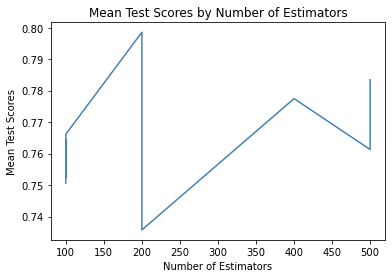

In [23]:
# Plot the scores
plt.title('Mean Test Scores by Number of Estimators')
plt.plot(estimators, dist_mean_scores, color='steelblue')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Scores')

In [24]:
# Examine the best score
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.7985444690810545
{'n_estimators': 100, 'max_features': 'log2', 'max_depth': 1, 'learning_rate': 0.8}
GradientBoostingClassifier(learning_rate=0.8, max_depth=1, max_features='log2',
                           random_state=42)


#### Use the Best Parameters to Make Predictions Using the Hold-Out Data

In [25]:
%%time

n_estimators = rand.best_params_['n_estimators']
learning_rate = rand.best_params_['learning_rate']
max_feature = rand.best_params_['max_features']
max_depth = rand.best_params_['max_depth']

gbc = GradientBoostingClassifier(n_estimators = n_estimators
                                 , learning_rate = learning_rate
                                 , max_features = max_feature
                                 , max_depth = max_depth
                                 , random_state = 42
                            )

gbc.fit(X, y)

y_pred = rand.predict(X_eval)
y_probs = rand.predict_proba(X_eval)

CPU times: user 185 ms, sys: 4 µs, total: 185 ms
Wall time: 184 ms


#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.808
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.735
----------------------------------------------------------------------------------
True: [1, 0, 0, 1, 0, 1, 0, 0, 1, 1]
Pred: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions    0    1
Actuals              
0            939   97
1            174  199
-------------------------------------------------------
Area Under the Curve (AUC): 0.859
-------------------------------------------------------

-------------------------------------------------------
Classification Report
------------------

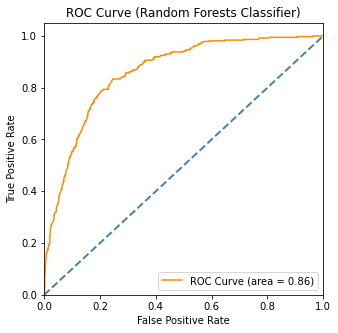

In [26]:
show_accuracy(y_eval, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_eval, y_pred, y_probs, CLASSIFICATION_TYPE)
show_classification_report(y_eval, y_pred)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_eval, y_probs, 'Random Forests Classifier')

#### Use K-Fold Cross-Validation to Detect Overfitting

In [27]:
%%time

show_cv_classification_report(gbc, X, y, 10)

--------------------------------------------------------------------------------------------
Accuracy per Fold:  [0.78368794 0.82624113 0.79432624 0.80673759 0.77619893 0.80284192
 0.79573712 0.79573712 0.76554174 0.78685613]
Average Accuracy: 0.793
Standard Deviation of Accuracy: 0.016
--------------------------------------------------------------------------------------------
Precision per Fold:  [0.76878069 0.82085482 0.78559169 0.79604477 0.76472289 0.79089969
 0.78392736 0.78430839 0.74658475 0.77286214]
Average Precision: 0.781
Standard Deviation of Precision: 0.019
--------------------------------------------------------------------------------------------
Recall per Fold:  [0.78368794 0.82624113 0.79432624 0.80673759 0.77619893 0.80284192
 0.79573712 0.79573712 0.76554174 0.78685613]
Average Recall: 0.793
Standard Deviation of Recall: 0.016
--------------------------------------------------------------------------------------------
F1 per Fold:  [0.76979305 0.82254414 0.7882807

#### Export the Best Fit Model to a Pickle file.

In [28]:
export_model(gbc, "GradiantBoostingClassifier")